In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_squared_error, accuracy_score
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

#Understanding the Data

#Read in the Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# 1. Load data
url = "https://health.data.ny.gov/resource/tg3i-cinn.csv"
df = pd.read_csv(url)

In [4]:
# 2. Preview / basic info
df.head()

,hospital_service_area,hospital_county,operating_certificate_number,permanent_facility_id,facility_name,age_group,zip_code_3_digits,gender,race,ethnicity,...,apr_severity_of_illness,apr_risk_of_mortality,apr_medical_surgical,payment_typology_1,payment_typology_2,payment_typology_3,birth_weight,emergency_department_indicator,total_charges,total_costs
0,New York City,Bronx,7000006.0,1169.0,Montefiore Medical Center - Henry & Lucy Moses...,70 or Older,104,M,Other Race,Spanish/Hispanic,...,Major,Extreme,Medical,Medicare,Medicaid,NaN,NaN,Y,320922.43,60241.34
1,New York City,Bronx,7000006.0,1169.0,Montefiore Medical Center - Henry & Lucy Moses...,50 to 69,104,F,White,Not Span/Hispanic,...,Moderate,Minor,Medical,Private Health Insurance,NaN,NaN,NaN,Y,61665.22,9180.69
2,New York City,Bronx,7000006.0,1168.0,Montefiore Medical Center-Wakefield Hospital,18 to 29,104,F,Other Race,Spanish/Hispanic,...,Minor,Minor,Surgical,Medicaid,NaN,NaN,NaN,N,42705.34,11366.50
3,New York City,Bronx,7000006.0,3058.0,Montefiore Med Center - Jack D Weiler Hosp of ...,70 or Older,104,M,Other Race,Spanish/Hispanic,...,Major,Major,Medical,Medicare,Medicaid,NaN,NaN,Y,72700.17,12111.75
4,New York City,Bronx,7000006.0,1169.0,Montefiore Medical Center - Henry & Lucy Moses...,50 to 69,104,F,Black/African American,Not Span/Hispanic,...,Moderate,Minor,Medical,Medicare,Medicaid,NaN,NaN,Y,55562.51,8339.72


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 33 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hospital_service_area           995 non-null    object 
 1   hospital_county                 995 non-null    object 
 2   operating_certificate_number    995 non-null    float64
 3   permanent_facility_id           995 non-null    float64
 4   facility_name                   1000 non-null   object 
 5   age_group                       1000 non-null   object 
 6   zip_code_3_digits               977 non-null    object 
 7   gender                          1000 non-null   object 
 8   race                            1000 non-null   object 
 9   ethnicity                       1000 non-null   object 
 10  length_of_stay                  1000 non-null   object 
 11  type_of_admission               1000 non-null   object 
 12  patient_disposition             100

In [6]:
df.describe()

,operating_certificate_number,permanent_facility_id,discharge_year,apr_drg_code,apr_mdc_code,apr_severity_of_illness_code,birth_weight,total_charges,total_costs
count,9.950000e+02,995.000000,1000.0,1000.000000,1000.000000,1000.00000,188.000000,1.000000e+03,1.000000e+03
mean,6.939185e+06,1461.255276,2021.0,502.045000,12.391000,1.95800,3123.936170,6.035763e+04,2.683414e+04
std,4.024881e+05,487.682229,0.0,242.348315,6.002512,0.83122,650.060825,1.223705e+05,5.155740e+04
min,4.324000e+06,776.000000,2021.0,4.000000,1.000000,1.00000,600.000000,5.502900e+03,5.636700e+02
25%,7.000008e+06,1172.000000,2021.0,253.750000,6.000000,1.00000,2900.000000,1.681359e+04,7.217405e+03
50%,7.001016e+06,1301.000000,2021.0,560.000000,14.000000,2.00000,3200.000000,2.985722e+04,1.450116e+04
75%,7.002001e+06,1456.000000,2021.0,720.000000,18.000000,2.00000,3500.000000,6.256464e+04,2.947724e+04
max,7.003007e+06,3058.000000,2021.0,951.000000,25.000000,4.00000,5000.000000,1.983105e+06,1.125848e+06


#Understanding the Features/Columns

1. Patient Demographics
- age_group → Age ranges (e.g., 0–17, 18–29, 30–49, 50–69, 70+)Useful for grouping patients by age category.
- gender → Male/Female/Other.
race → Race categories (White, Black, Asian/Pacific Islander, Other).
- ethnicity → Hispanic / Non-Hispanic.
- zip_code_3_digits → First 3 digits of patient ZIP (for geography).

2. Admission & Discharge Information
- type_of_admission → How patient was admitted: Emergency, Elective, Trauma, Newborn.
- patient_disposition → Status at discharge: home, rehab, skilled nursing, expired, transferred.
- emergency_department_indicator → Y/N if admitted via ED.
- discharge_year → Year of discharge (time-based trends).

3. Clinical Classifications
- ccsr_diagnosis_code / ccsr_diagnosis_description → Diagnosis category (based on ICD → CCSR grouping).
- ccsr_procedure_code / ccsr_procedure_description → Procedure category.
- apr_drg_code / apr_drg_description → All-Patient Refined DRG (Diagnosis Related Group).
- apr_mdc_code / apr_mdc_description → Major Diagnostic Category.
- apr_severity_of_illness_code / apr_severity_of_illness → Severity level (1=Minor, 2=Moderate, 3=Major, 4=Extreme).
- apr_risk_of_mortality → Mortality risk category (Minor, Moderate, Major, Extreme).
- apr_medical_surgical → Medical vs Surgical case.

4. Hospital Identifiers
- hospital_service_area → Regional service area.
- hospital_county → County where hospital is located.
- facility_name → Hospital facility name.
- operating_certificate_number, permanent_facility_id → Hospital identifiers.

5. Financial Variables
- payment_typology_1 / 2 / 3 → Primary, secondary, tertiary payer (Medicare, Medicaid, private insurance, self-pay).
- total_charges → Amount billed to patient/insurer.
- total_costs → Estimated hospital cost of the stay.

6. Outcome Variable
- length_of_stay → Number of days patient stayed in hospital (integer, sometimes capped as “120+”).
- Target for regression.
- Distribution is usually right-skewed (most short stays, few very long ones).

##Dealing with missing values and One-hot encoding

In [7]:
#checking shape before modifying data
df.shape

(1000, 33)

In [8]:
# 3. Check missing values
df.isnull().sum().sort_values(ascending=False)

,0
payment_typology_3,960
birth_weight,812
payment_typology_2,748
ccsr_procedure_description,245
ccsr_procedure_code,245
zip_code_3_digits,23
hospital_service_area,5
permanent_facility_id,5
hospital_county,5
operating_certificate_number,5


In [9]:
#drop duplicates
df.drop_duplicates(inplace=True)

In [10]:
# Drop unnecessary columns
df = df.drop(columns=['operating_certificate_number','permanent_facility_id','facility_name','total_charges', 'total_costs',
                      'payment_typology_2','payment_typology_3','birth_weight','zip_code_3_digits','ccsr_procedure_description','ccsr_procedure_code'])

In [11]:
# First, convert everything to string so .str methods work
df['length_of_stay'] = df['length_of_stay'].astype(str)

# Remove "+" signs if they exist (e.g., "120+")
df['length_of_stay'] = df['length_of_stay'].str.replace('+', '', regex=False)

# Convert back to numeric
df['length_of_stay'] = pd.to_numeric(df['length_of_stay'], errors='coerce')


In [12]:
print(df['length_of_stay'].describe())

count    999.000000
mean       6.491491
std       10.705367
min        1.000000
25%        2.000000
50%        3.000000
75%        7.000000
max      120.000000
Name: length_of_stay, dtype: float64


In [13]:
df.isnull().sum().sort_values(ascending=False)

,0
hospital_service_area,5
hospital_county,5
age_group,0
gender,0
race,0
ethnicity,0
length_of_stay,0
type_of_admission,0
patient_disposition,0
discharge_year,0


In [14]:
print(df.shape)

(999, 22)



Several columns were removed from the dataset because they were either identifiers, post-discharge variables, or provided little predictive value. Hospital identifiers (operating_certificate_number, permanent_facility_id, facility_name) were dropped since they don’t describe patient or clinical characteristics. Financial outcomes (total_charges, total_costs) were excluded to avoid data leakage, as they are only known after discharge. Secondary/tertiary payment fields, birth weight, and partial ZIP codes were removed due to high missingness, sparsity, or limited relevance. Finally, CCSR procedure codes and descriptions were dropped because they overlap with existing diagnosis/severity fields and add redundant complexity. This ensures the model uses only clinically meaningful, admission-time features.

### Outlier Analysis

count    999.000000
mean       6.491491
std       10.705367
min        1.000000
25%        2.000000
50%        3.000000
75%        7.000000
max      120.000000
Name: length_of_stay, dtype: float64


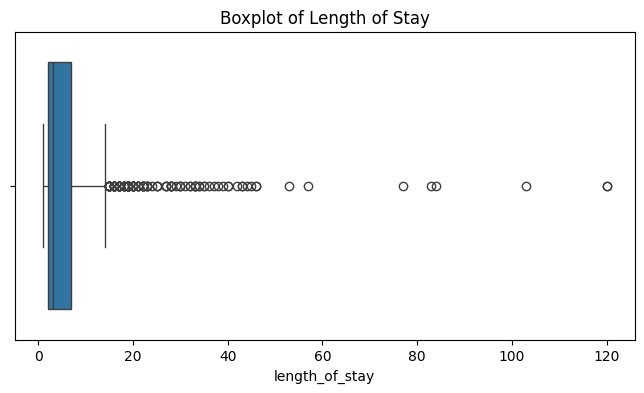

Number of stays >30 days: 32
length_of_stay
44     1
45     1
46     2
53     1
57     1
77     1
83     1
84     1
103    1
120    2
Name: count, dtype: int64


In [15]:
# Summary statistics
print(df['length_of_stay'].describe())

# Boxplot to visualize outliers
plt.figure(figsize=(8,4))
sns.boxplot(x=df['length_of_stay'])
plt.title("Boxplot of Length of Stay")
plt.show()

# Count extreme long stays (e.g., >30 days)
outliers = df[df['length_of_stay'] > 30]
print(f"Number of stays >30 days: {len(outliers)}")
print(outliers['length_of_stay'].value_counts().sort_index().tail(10))

Outlier analysis of the target variable (length_of_stay) shows a highly skewed distribution with most patients staying under 7 days, but a small fraction of admissions extending beyond 30 days (up to 120). These extreme cases are clinically valid and represent high-severity conditions rather than errors. For this project, we retain all values but apply a log transformation during modeling to reduce skewness and lessen the impact of extreme outliers on model performance.

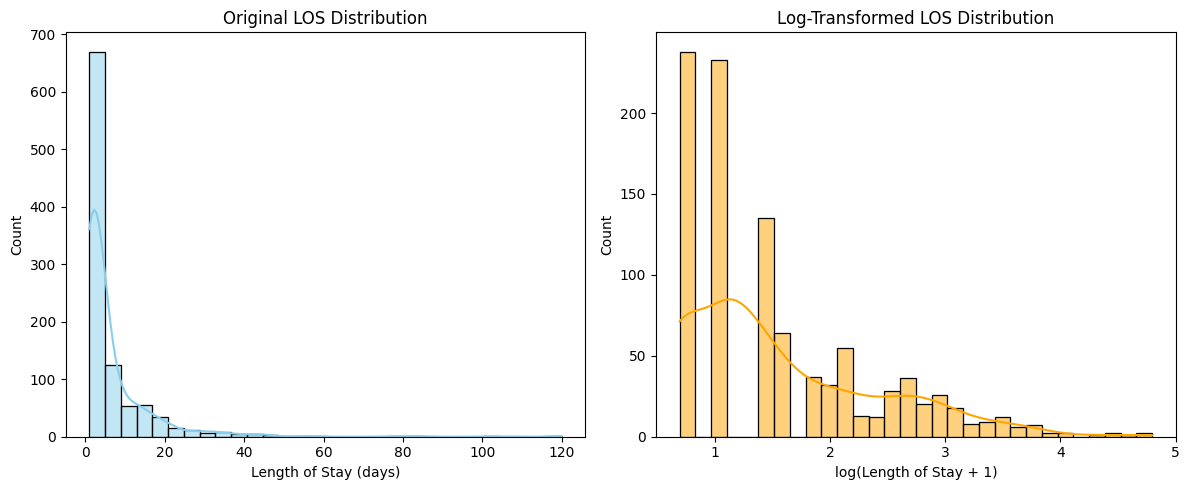

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Log transform (adding 1 so zero stays valid)
df['log_los'] = np.log1p(df['length_of_stay'])

# Plot original vs log-transformed side by side
fig, axes = plt.subplots(1, 2, figsize=(12,5))

sns.histplot(df['length_of_stay'], bins=30, kde=True, ax=axes[0], color="skyblue")
axes[0].set_title("Original LOS Distribution")
axes[0].set_xlabel("Length of Stay (days)")

sns.histplot(df['log_los'], bins=30, kde=True, ax=axes[1], color="orange")
axes[1].set_title("Log-Transformed LOS Distribution")
axes[1].set_xlabel("log(Length of Stay + 1)")

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Module 20 : Ensemble Techniques /images/los_dist.png')
plt.show()

# Exploratory Data Analysis

### Univariate Numerical Analysis

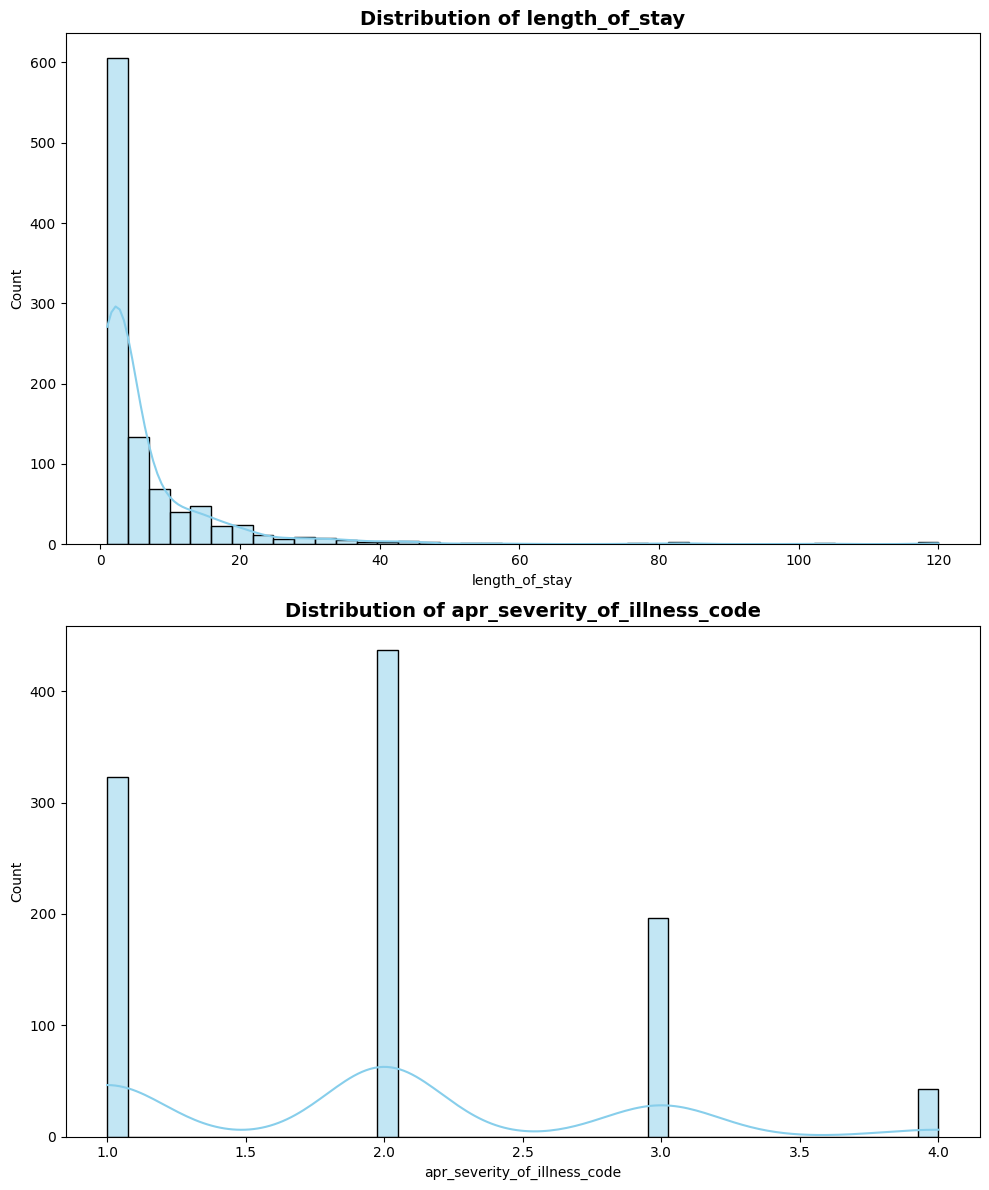

In [17]:
# Select numerical columns (excluding target if desired)
numerical_cols = ['length_of_stay', 'apr_severity_of_illness_code']

# Plot distribution for each numerical feature
fig, axes = plt.subplots(nrows=len(numerical_cols), ncols=1, figsize=(10, 6 * len(numerical_cols)))
for ax, col in zip(axes, numerical_cols):
    sns.histplot(df[col].dropna(), bins=40, kde=True, color='skyblue', ax=ax)
    ax.set_title(f'Distribution of {col}', fontsize=14, fontweight='bold')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Module 20 : Ensemble Techniques /images/num_distribution.png')
plt.show()

###Univariate Categorical Analysis

/tmp/ipython-input-19261604.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, order=df[col].value_counts().index, palette="Set2", ax=ax)
/tmp/ipython-input-19261604.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
/tmp/ipython-input-19261604.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, order=df[col].value_counts().index, palette="Set2", ax=ax)
/tmp/ipython-input-19261604.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax

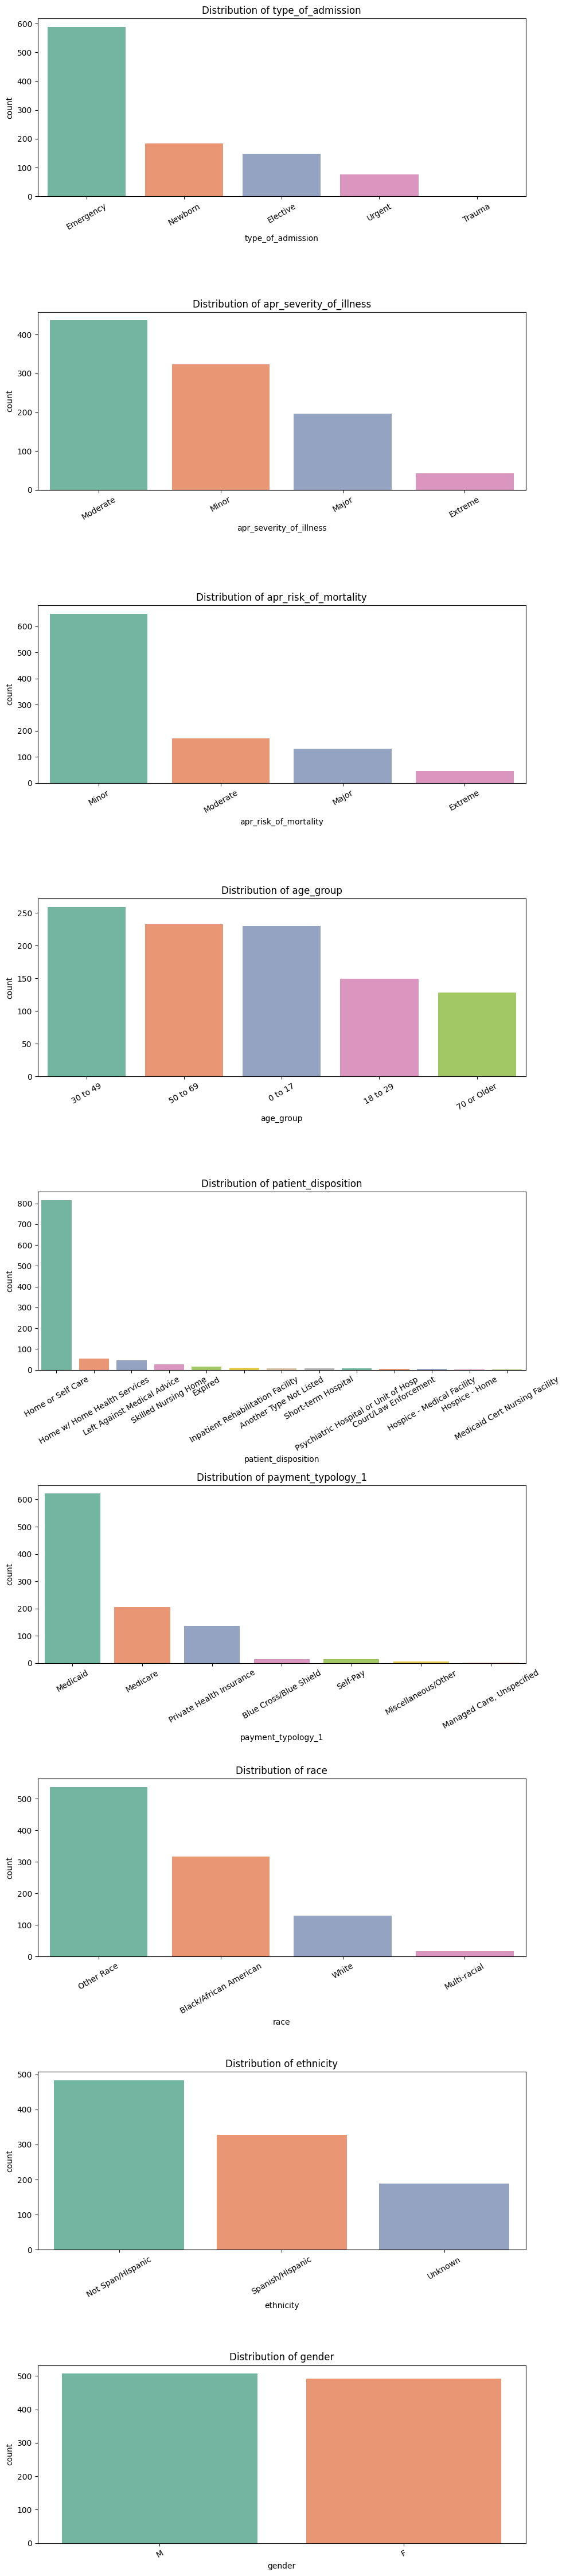

In [18]:
cat_cols = ['type_of_admission','apr_severity_of_illness','apr_risk_of_mortality','age_group','patient_disposition','payment_typology_1','race','ethnicity','gender']
fig, axes = plt.subplots(nrows=len(cat_cols), ncols=1, figsize=(10, 5 * len(cat_cols)))
for ax, col in zip(axes, cat_cols):
    sns.countplot(x=col, data=df, order=df[col].value_counts().index, palette="Set2", ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    ax.set_title(f"Distribution of {col}")

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Module 20 : Ensemble Techniques /images/cat_distribution.png')
plt.show()

### Multivariates Numerical Analysis

/tmp/ipython-input-717371407.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


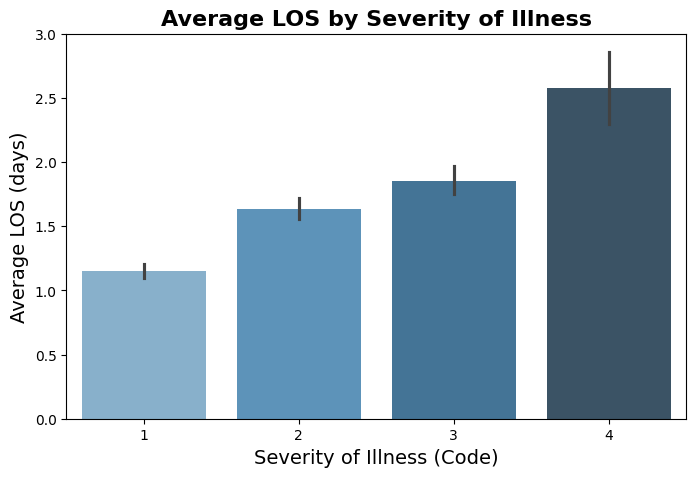

In [19]:

# --- Barplot: Average LOS by severity ---
plt.figure(figsize=(8,5))
sns.barplot(
    x="apr_severity_of_illness_code",
    y='log_los',
    data=df,
    estimator=np.mean,
    palette="Blues_d"
)
plt.title("Average LOS by Severity of Illness", fontsize=16, weight="bold")
plt.xlabel("Severity of Illness (Code)", fontsize=14)
plt.ylabel("Average LOS (days)", fontsize=14)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Module 20 : Ensemble Techniques /images/los_by_severe.png')
plt.show()

### Multivariates Categorical Analysis

/tmp/ipython-input-464475691.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, y='log_los', data=df, palette="coolwarm", ax=ax)
/tmp/ipython-input-464475691.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
/tmp/ipython-input-464475691.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, y='log_los', data=df, palette="coolwarm", ax=ax)
/tmp/ipython-input-464475691.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),

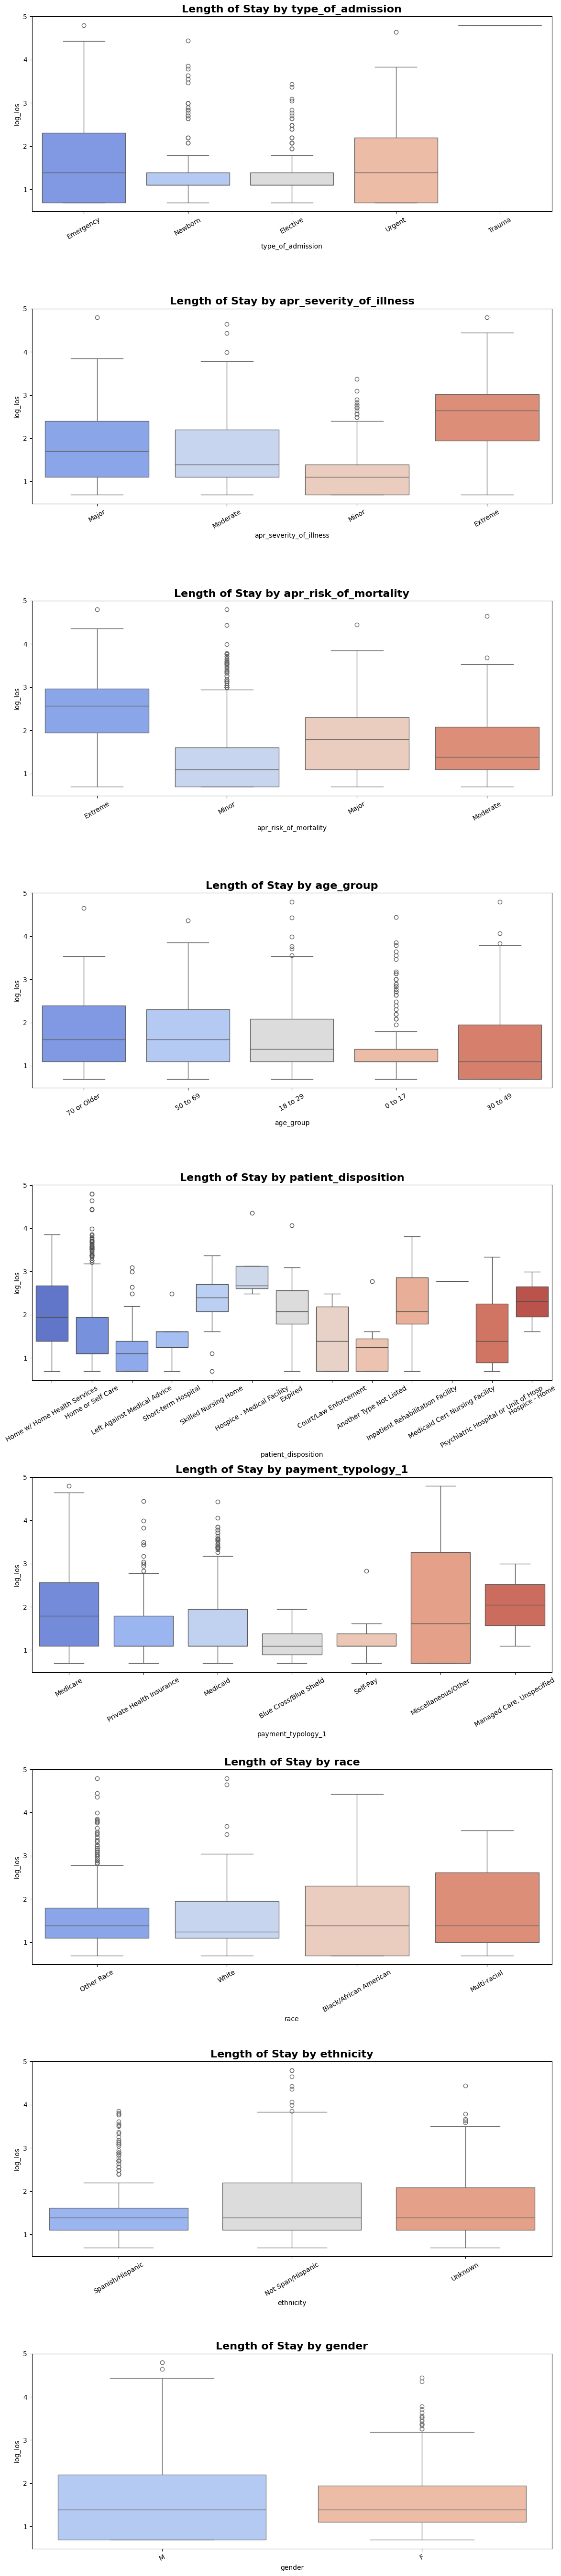

In [20]:
fig, axes = plt.subplots(nrows=len(cat_cols), ncols=1, figsize=(12, 6 * len(cat_cols)))
for ax, col in zip(axes, cat_cols):
    sns.boxplot(x=col, y='log_los', data=df, palette="coolwarm", ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    ax.set_title(f"Length of Stay by {col}", fontsize=16, weight="bold")

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Module 20 : Ensemble Techniques /images/multi_cat.png', bbox_inches='tight')
plt.show()

[link text](https://)

/tmp/ipython-input-3259592023.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


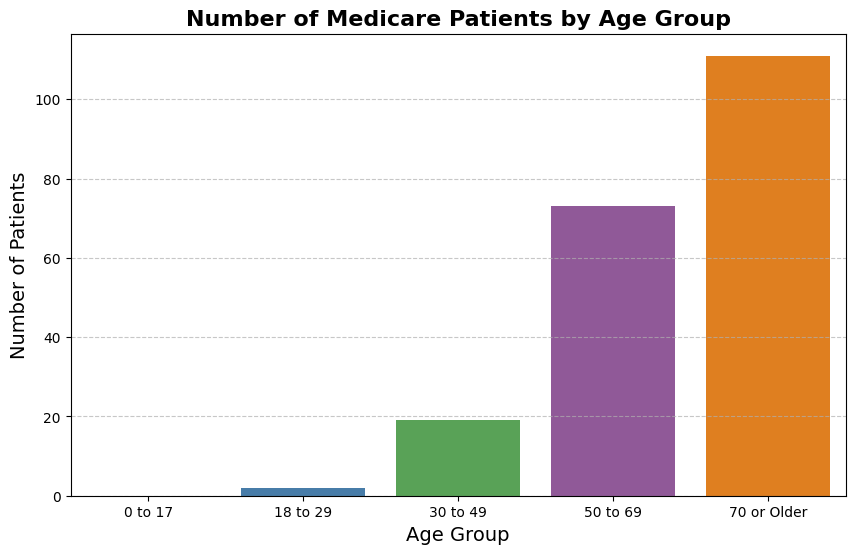

In [21]:
# Filter Medicare patients
medicare_df = df[df['payment_typology_1'] == 'Medicare']

# Create plot
plt.figure(figsize=(10,6))
sns.countplot(
    x="age_group",
    data=medicare_df,
    order=['0 to 17','18 to 29','30 to 49','50 to 69','70 or Older'],
    palette="Set1"
)
plt.title("Number of Medicare Patients by Age Group", fontsize=16, weight="bold")
plt.xlabel("Age Group", fontsize=14)
plt.ylabel("Number of Patients", fontsize=14)
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Module 20 : Ensemble Techniques /images/medicare_age.png')
plt.show()

#Distribution Analysis
##Numerical Features

###Length of Stay (LOS):
- Distribution is right-skewed, with most patients staying 2–7 days.
- Median is 3 days, but a few outliers extend up to 120 days
- Capping or log-transforming LOS could help stabilize modeling.


###Severity of Illness Code (numeric 1–4):
- LOS increases stepwise with the severity code.
- Acts as an ordinal variable and aligns well with the categorical severity labels.


##Categorical Features

###Type of Admission:
- Emergency admissions dominate and show longer LOS on average.
- Elective admissions tend to be shorter, reflecting planned care.
- Newborn admissions are short but with some outliers.

###Severity of Illness:
- Extreme severity patients have the longest median LOS.
- Clear gradient: Minor → Moderate → Major → Extreme.
- One of the strongest predictors of LOS.
###Risk of Mortality:
- Higher mortality risk correlates with longer LOS, though extreme-risk patients show greater variability (some very short stays due to death).
- Strong complement to severity.

###Age Group:
- Older patients (especially 70+) stay significantly longer.
- Younger groups (0–17, 18–29) show shorter stays.
- Age amplifies Medicare’s effect on LOS.
###Patient Disposition:
- Home discharges have the shortest stays.
- Transfers to rehab/skilled nursing show much longer LOS.
- Expired patients show a split: some very short stays, others very long.

###Payment Typology 1:
- Medicare patients have the longest stays, linked to age and comorbidities.
- Private insurance/self-pay generally result in shorter LOS.
- Reflects both demographic and system-level influences.

###Gender
- The counts for "M" (male) and "F" (female) are very similar, each just under or above 500. This indicates a balanced representation of gender in the sampled data

### Race
- "Other Race" is the largest group, significantly higher than others, followed by "Black/African American."

- "White" and "Multi-racial" are much less frequent — "Multi-racial" is especially rare in this sample.

### Ethnicity
- "Spanish/Hispanic" is the most prominent group, with "Non-Hispanic" and "Unknown" following. "Unknown" still holds a measured portion, highlighting some missing/undisclosed data

##Interaction Effects
- Severity × Type of Admission: Emergency + High severity → longest LOS.
- Age × Payment Type: Medicare patients in 70+ group drive much of the LOS burden.
- Disposition × Severity: Severe cases that transition to rehab/nursing stay longest.

##Bivariate Analyisis

###Type of Admission vs Length of Stay
- Emergency admissions dominate the sample and are associated with longer lengths of stay on average.
- Elective admissions tend to be shorter, reflecting planned care.
- Newborn admissions are short, but with some outliers.

###Severity of Illness vs Length of Stay
- Length of stay increases stepwise with the severity code (Minor, Moderate, Major, Extreme).
- Patients with "Extreme" severity have the longest median stays.
- Severity of illness is a strong predictor of length of stay.

###Risk of Mortality vs Length of Stay
- Higher risk of mortality correlates with longer stays.
- "Extreme" risk patients show greater variability; some have very short stays (often due to mortality), others longer.

###Age Group vs Length of Stay
- Older patients, especially those aged 70 or older, stay significantly longer in the hospital.
- Younger groups (0–17, 18–29) have the shortest stays.

###Patient Disposition vs Length of Stay
- Patients discharged to home have the shortest stays.
- Transfers to rehab or skilled nursing show much longer hospital stays.
- Expired patients show a split: some have very short stays, others much longer, revealing heterogeneity in end-of-life care.

###Payment Typology vs Length of Stay
- Medicare patients have the longest stays; associated with older age and complex conditions.
- Private insurance and self-pay result in shorter stays.

###Gender
- There is no significant difference in the distribution of length of hospital stay between males and females, suggesting that gender is not strongly associated with hospital utilization in this sample

###Race
- "Other Race" is the predominant group, followed by "Black/African American." "White" and "Multi-racial" individuals are much less represented.
- There are no drastic differences in median hospital stay across racial groups, but smaller sample sizes for less-represented races may limit the reliability of group comparisons.
- The large "Other Race" group suggests broad classification, which might mask subgroup trends and should be interpreted with caution

###Ethnicity
- "Spanish/Hispanic" and "Non-Hispanic" are the major categories, with "Unknown" also present in substantial amounts.

- Distribution of length of stay is similar for both main ethnicity groups, but "Unknown" has broader variability, possibly due to missing or undisclosed data.

- Ethnicity is moderately well-captured, but the significant "Unknown" count means some trends may be ambiguous or less interpretable.

#Correlation Map

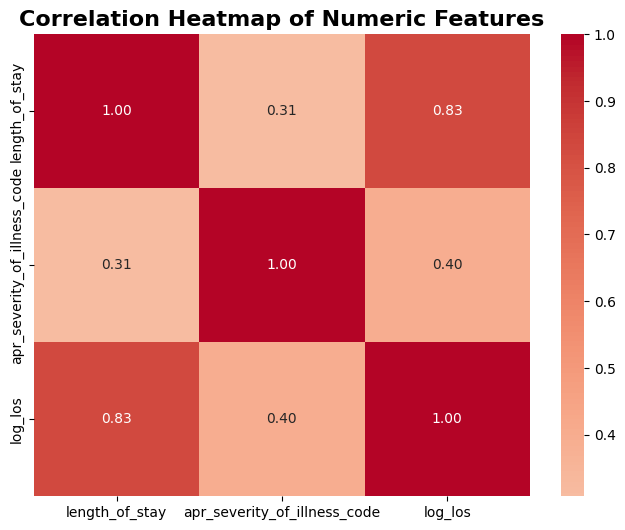

In [22]:
# Compute correlation matrix
num_features = ['length_of_stay','apr_severity_of_illness_code', 'log_los']
corr_matrix = df[num_features].corr()

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Correlation Heatmap of Numeric Features", fontsize=16, weight="bold")
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Module 20 : Ensemble Techniques /images/corr_map.png')
plt.show()

#Correlation Heatmap of Numeric Features — Interpretation


The heatmap shows a moderate positive correlation (0.40) between length of stay(log) and severity of illness, indicating that patients with higher severity scores generally stay longer, though other clinical and demographic factors also play an important role in predicting LOS.

#Understanding the Task

#Engineering Features

In [23]:
features = [
    'age_group', 'gender', 'race', 'ethnicity',
    'type_of_admission', 'patient_disposition',
    'apr_severity_of_illness', 'apr_risk_of_mortality', 'payment_typology_1',
    'discharge_year'
]
X = df[features]
y = df['log_los']

In [24]:
df['log_los'].value_counts()

,count
log_los,
0.693147,238
1.098612,233
1.386294,135
1.609438,64
1.791759,37
1.945910,32
2.079442,30
2.197225,25
2.708050,22


In [25]:
# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(exclude=['object']).columns.tolist()

#Train/Test Split

In [26]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#A Baseline Model

In [27]:
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Initialize Dummy Regressor - predicts mean of target
dummy_reg = DummyRegressor(strategy='mean')
dummy_reg.fit(X_train, y_train)


DummyRegressor()

In [28]:
# Predict on test data
y_pred = dummy_reg.predict(X_test)

In [29]:
# Evaluate
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Dummy Regressor Mean Squared Error: {mse}")
print(f"Dummy Regressor Mean Absolute Error: {mae}")
print(f"Dummy Regressor R-squared: {r2}")

Dummy Regressor Mean Squared Error: 0.6154251245963713
Dummy Regressor Mean Absolute Error: 0.6536291580376619
Dummy Regressor R-squared: -0.0006932908686412276


The dummy regressor, which always predicts the mean LOS (~6.5 days), still provides the weakest baseline. It achieves a moderate MAE due to the dataset’s skew toward short stays but completely fails on extreme cases. As expected, the R² remains near zero, confirming that it does not capture any meaningful variance. This baseline underscores the need for incorporating meaningful clinical and demographic features.

#A Simple Model

In [30]:
# Identify categorical and numerical columns based on the features in X
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

In [31]:

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])


In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

# Create full pipeline with linear regression
line_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [33]:
# Train model
line_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['discharge_year']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['age_group', 'gender',
                                                   'race', 'ethnicity',
                                                   'type_of_admission',
                                                   'patient_disposition',
                                                   'apr_severity_of_illness',
                                                   'apr_risk_of_mortality',
                                                   'payment_typology_1'])])),
                ('regressor', LinearRegression())])

In [34]:
# Predict on test set
y_pred = line_pipeline.predict(X_test)

#Score the Model

In [35]:
# Evaluate

# Metrics
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print(f"Linear Regression Performance:")
print(f"  Mean Squared Error (MSE): {mse:.2f}")
print(f"  Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"  Mean Absolute Error (MAE): {mae:.2f}")
print(f"  R² Score: {r2:.3f}")

Linear Regression Performance:
  Mean Squared Error (MSE): 0.48
  Root Mean Squared Error (RMSE): 0.69
  Mean Absolute Error (MAE): 0.54
  R² Score: 0.223


###Linear Model Interpretation
The average error is reduced to about 4–5 days, which, while better than the raw baseline, is still large compared to the typical hospital stay (2–7 days).

The R² improves slightly but remains low, showing that the model explains only a limited portion of the variation in LOS.

This performance reflects the fact that, even after log transformation, LOS is driven by non-linear and interaction effects (e.g., trauma admissions, hospice transfers, and extreme illness severity) that a simple linear model cannot fully capture.

#Top Features with Linear (Baseline Model)

In [36]:
# Get feature names after one-hot encoding
ohe = line_pipeline.named_steps['preprocessor'].named_transformers_['cat']
encoded_cat_features = ohe.get_feature_names_out(categorical_cols)
all_features = np.concatenate([numerical_cols, encoded_cat_features])

# Get coefficients from linear model
coefs = line_pipeline.named_steps['regressor'].coef_

# Create dataframe of features and coefficient magnitudes
feat_coef_df = pd.DataFrame({
    'feature': all_features,
    'coef_magnitude': np.abs(coefs),
    'coefficient': coefs
}).sort_values(by='coef_magnitude', ascending=False)

top_features = feat_coef_df[feat_coef_df['coef_magnitude'] > 0]['feature'].tolist()

print("Top features by linear regression coefficient magnitude:")
print(feat_coef_df.head(10))

Top features by linear regression coefficient magnitude:
                                            feature  coef_magnitude  \
18                         type_of_admission_Trauma        1.595090   
26   patient_disposition_Hospice - Medical Facility        0.818241   
28  patient_disposition_Left Against Medical Advice        0.618532   
34                    apr_severity_of_illness_Minor        0.560238   
32                  apr_severity_of_illness_Extreme        0.541747   
15                       type_of_admission_Elective        0.514554   
20      patient_disposition_Another Type Not Listed        0.498043   
31         patient_disposition_Skilled Nursing Home        0.456783   
19                         type_of_admission_Urgent        0.415042   
16                      type_of_admission_Emergency        0.410983   

    coefficient  
18     1.595090  
26     0.818241  
28    -0.618532  
34    -0.560238  
32     0.541747  
15    -0.514554  
20    -0.498043  
31     0.456783  

In [37]:
# Extract feature names after preprocessing
preprocessor = line_pipeline.named_steps['preprocessor']
feature_names = preprocessor.get_feature_names_out()

# Get linear coefficients (for LinearRegression; shape matches feature_names)
coefs = line_pipeline.named_steps['regressor'].coef_

df_importance = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefs
})
df_importance['coef_magnitude'] = df_importance['coefficient'].abs()

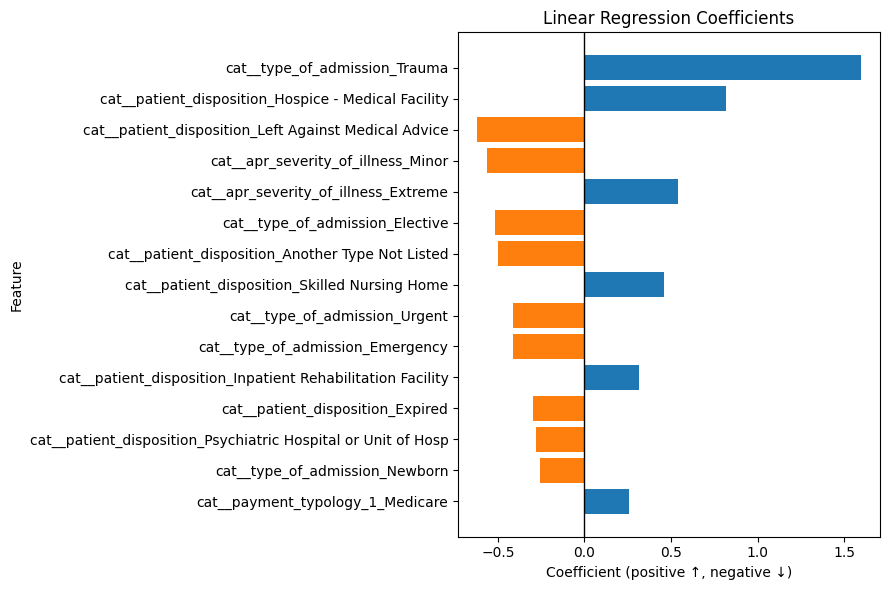

In [38]:
# df_importance: feature, coefficient, coef_magnitude
top_n = 15
df_plot = df_importance.nlargest(top_n, 'coef_magnitude').copy()
colors = np.where(df_plot['coefficient'] >= 0, 'tab:blue', 'tab:orange')

fig, ax = plt.subplots(figsize=(9, 6))
ax.barh(df_plot['feature'], df_plot['coefficient'], color=colors)
ax.axvline(0, color='k', linewidth=1)
ax.set_title('Linear Regression Coefficients')
ax.set_xlabel('Coefficient (positive ↑, negative ↓)')
ax.set_ylabel('Feature')
ax.invert_yaxis()  # largest at top
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Module 20 : Ensemble Techniques /images/linear_coef.png')
plt.show()

Type of Admission:
- Trauma admissions are the strongest positive driver, significantly increasing LOS.
- Elective and Newborn admissions show large negative coefficients, indicating shorter stays relative to the baseline category.

Patient Disposition:
- Being discharged to hospice is strongly associated with longer LOS.
- Leaving against medical advice reduces LOS, since patients self-discharge early.

Severity of Illness:
- Extreme severity increases LOS, while minor severity reduces it.
- Confirms the expected clinical relationship between severity and hospital stay duration.

Other factors (like “another type not listed” in disposition) also had moderate effects, reflecting administrative or rare discharge pathways.

#Model Comparisons

# Improving the Model